# Utilizing Multiple Vectors and  Advanced Search Data Model Design

# Goal of this Application

In this application, we will build an advanced data model and use it for ingest and various search options.   For this notebook portion, we will run a hybrid multi-vector search, re-rank the results and display the resulting text and images.

### 1️⃣ Ingest Data Fields, Enrich Data With Lookups, and Format:
Learn to ingest data from including JSON and Images, format and transform to optimize hybrid searches.   This is done inside the streetcams.py application.

### 2️⃣ Store Data into Milvus:
Learn to store data into Milvus, an efficient vector database designed for high-speed similarity searches and AI applications.   In this step we are optimizing data model with scalar and multiple vector fields -- one for text and one for the camera image.   We do this in the streetcams.py application.

### 3️⃣ Use Open Source Models for Data Queries in a Hybrid Multi-Modal, Multi-Vector Search:
Discover how to use scalars and multiple vectors to query data stored in Milvus and re-rank the final results in this notebook.

### 4️⃣ Display Resulting Text and Images:
Build a quick output for validation and checking in this notebook.

### 5️⃣ Simple Retrieval-Augmented Generation (RAG) with LangChain:
Build a simple Python [RAG](https://milvus.io/docs/integrate_with_langchain.md) application (streetcamrag.py) to use Milvus for asking about the current weather via OLLAMA.   While outputing to the screen we also send the results to Slack formatted as Markdown.

# 🔍 Summary
By the end of this application, you’ll have a comprehensive understanding of using Milvus, data ingest object semi-structured and unstructured data, and using Open Source models to build a robust and efficient data retrieval system.   For future enhancements, we can use these results to build prompts for LLM, slack bots, streaming data to Kafka and as a Street Camera search engine.





# Milvus
Milvus is an open-source vector database that powers AI applications with vector embeddings and similarity search.

In this notebook, we use Milvus Lite, it is the lightweight version of Milvus.

With Milvus Lite, you can start building an AI application with vector similarity search within minutes! Milvus Lite is good for running in the following environment:

* Jupyter Notebook / Google Colab
* Laptops
* Edge Devices like Raspberry Pi 5 and NVIDIA Jetson AGX Orin 

You can get more details in the [Milvus Quickstart](https://milvus.io/docs/quickstart.md).

🤖 For other options for running Milvus, check out the [deployment page](https://milvus.io/docs/install-overview.md).

![Milvus Deployment](https://milvus.io/docs/v2.4.x/assets/select-deployment-option.png)


# New York City 511 Data

* REST Feed of Street Camera Information with Latitude, Longitude, Roadway Name, Camera Name, Camera URL, Disabled Flag and Blocked Flag.


````
{"Latitude":43.004452,"Longitude":-78.947479,"ID":"NYSDOT-aibm5ihj4vo","Name":"I-190 at Interchange 18B","DirectionOfTravel":"Unknown","RoadwayName":"I-190 Niagara Thruway","Url":"https://511ny.org/map/Cctv/aibm5ihj4vo--43","VideoUrl":"https://s58.nysdot.skyvdn.com:443/rtplive/TA_167/playlist.m3u8","Disabled":true,"Blocked":false}
````

* Last Camera Image


![camimg](https://github.com/tspannhw/AIM-NYCStreetCams/blob/main/MultipleVectorsAdvanced%20SearchDataModelDesign/20240828130913_2a09b209-49eb-4804-8e26-baeefa2e29ec.png?raw=true)

# NOAA Forecast / Current Conditions Weather Feed

* REST Feed of Weather for a given latitude and longitude includes Observation Date, Temperature, Relative Humidity, Dewpoint, Wind Speed, Wind Direction,
  Weather description, Altimeter and Visibility.

![diagram](https://github.com/tspannhw/AIM-NYCStreetCams/raw/main/MultipleVectorsAdvanced%20SearchDataModelDesign/Untitled-2024-06-10-1526.png?raw=true)



# 511NY Traffic Camera Data

* REST feed of 511NY Traffic Camera Data including Latitude, Longitude, Name of Camera, Name of Roadway, Direction of Travel and most importantly URL of street camera

````
{"Latitude":42.69611,"Longitude":-73.84414,"ID":"Skyline-9880","Name":"I-87 MP 147.80 NB Just South of Interchange 24 (Albany/I-90/I-87)","DirectionOfTravel":"Northbound","RoadwayName":"I-87 - NYS Thruway","Url":"https://511ny.org/map/Cctv/9880--43","VideoUrl":"https://s58.nysdot.skyvdn.com:443/rtplive/TA_073/playlist.m3u8","Disabled":false,"Blocked":false}
````

* URL Endpoint for Camera image  


![image.png](https://github.com/tspannhw/AIM-NYCStreetCams/blob/main/MultipleVectorsAdvanced%20SearchDataModelDesign/yolo25781c43-b743-4cca-91f2-6c7436643ff3.png?raw=true)


# NOAA Weather Current Conditions for Lat/Long

* REST feed for Weather conditions meeting latitude and longitude passed in includes elevation, observation date, wind speed, wind direction, visibility, relative 
  humidity and temperature.


````
"currentobservation":{
            "id":"KLGA",
            "name":"New York, La Guardia Airport",
            "elev":"20",
            "latitude":"40.78",
            "longitude":"-73.88",
            "Date":"27 Aug 16:51 pm EDT",
            "Temp":"83",
            "Dewp":"60",
            "Relh":"46",
            "Winds":"14",
            "Windd":"150",
            "Gust":"NA",
            "Weather":"Partly Cloudy",
            "Weatherimage":"sct.png",
            "Visibility":"10.00",
            "Altimeter":"1017.1",
            "SLP":"30.04",
            "timezone":"EDT",
            "state":"NY",
            "WindChill":"NA"
        }
````

# Install Dependencies

In [ ]:
! pip3 install pymilvus python-dotenv pymilvus[model]

In [ ]:
! pip3 install  timm torch numpy scikit-learn ultralytics pillow

In [1]:
from __future__ import print_function
import requests
import sys
import io
import json
import shutil
import sys
import datetime
import subprocess
import sys
import os
import math
import base64
from time import gmtime, strftime
import random, string
import time
import psutil
import base64
import uuid
import socket
from pymilvus import connections
from pymilvus import utility
from pymilvus import FieldSchema, CollectionSchema, DataType, Collection
import torch
from torchvision import transforms
from PIL import Image
import timm
from sklearn.preprocessing import normalize
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
from pymilvus import MilvusClient
import os
from IPython.display import display


In [2]:
"""
load_dotenv reads key-value pairs from a .env file and can set them as environment variables.
This is useful to avoid leaking your API key for example :D
"""

from dotenv import load_dotenv

load_dotenv()

True

## Prepare Hugging Face Sentence Transformers for Embedding Sentence Text

We utilize a model from Hugging Face, "all-MiniLM-L6-v2", a sentence transformer to build our Dense embedding for our short text strings.   This text is a short description of the weather details for the nearest location to our street camera.

See:   [Integrate with HuggingFace](https://milvus.io/docs/integrate_with_hugging-face.md)


In [3]:
from pymilvus import model
from pymilvus.model.dense import SentenceTransformerEmbeddingFunction

model = SentenceTransformerEmbeddingFunction('all-MiniLM-L6-v2',device='cpu' )

/Users/timothyspann/Downloads/code/milvusvenv/lib/python3.12/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/Users/timothyspann/Downloads/code/milvusvenv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Users/timothyspann/Downloads/code/milvusvenv/lib/python3.12/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/Users/timothyspann/Downloads/code/milvusvenv/lib/python3.12/site-packages/transformers/utils/generic.py:309:

## Prepare Embedding Model for Images

We utilize a standard *resnet34* Pytorch feature extractor that we often use for images.


In [4]:
class FeatureExtractor:
    def __init__(self, modelname):
        # Load the pre-trained model
        self.model = timm.create_model(
            modelname, pretrained=True, num_classes=0, global_pool="avg"
        )
        self.model.eval()

        # Get the input size required by the model
        self.input_size = self.model.default_cfg["input_size"]

        config = resolve_data_config({}, model=modelname)
        # Get the preprocessing function provided by TIMM for the model
        self.preprocess = create_transform(**config)

    def __call__(self, imagepath):
        # Preprocess the input image
        input_image = Image.open(imagepath).convert("RGB")  # Convert to RGB if needed
        input_image = self.preprocess(input_image)

        # Convert the image to a PyTorch tensor and add a batch dimension
        input_tensor = input_image.unsqueeze(0)

        # Perform inference
        with torch.no_grad():
            output = self.model(input_tensor)

        # Extract the feature vector
        feature_vector = output.squeeze().numpy()

        return normalize(feature_vector.reshape(1, -1), norm="l2").flatten()

extractor = FeatureExtractor("resnet34")

# Instantiate Milvus and Build Schema

[Milvus](https://milvus.io/) is a popular open-source vector database that powers AI applications with highly performant and scalable vector similarity search.

- For our example, we are connecting to Milvus running in Docker.
- Setting the uri as a local file, e.g.`./milvus.db`, is the most convenient method, as it automatically utilizes [Milvus Lite](https://milvus.io/docs/milvus_lite.md) to store all data in this file.
- If you have large scale of data, say more than a million vectors, you can set up a more performant Milvus server on [Docker or Kubernetes](https://milvus.io/docs/quickstart.md). In this setup, please use the server uri, e.g.`http://localhost:19530`, as your uri.
- If you want to use [Zilliz Cloud](https://zilliz.com/cloud), the fully managed cloud service for Milvus, adjust the uri and token, which correspond to the [Public Endpoint and API key](https://docs.zilliz.com/docs/on-zilliz-cloud-console#cluster-details) in Zilliz Cloud.

In [5]:
COLLECTION_NAME = 'nycstreetcameras' 

from pymilvus import (
    connections,
    db,
    FieldSchema,
    CollectionSchema,
    DataType,
    Collection,
    utility
)
from typing import List, Tuple
connections.connect(
    alias="default", 
    host="192.168.1.153",
    port="19530"
)

fields = [
    FieldSchema(name='id', dtype=DataType.INT64, is_primary=True, auto_id=True),
    FieldSchema(name='latitude', dtype=DataType.VARCHAR, max_length=200),
    FieldSchema(name='longitude', dtype=DataType.VARCHAR, max_length=200),
    FieldSchema(name='name', dtype=DataType.VARCHAR, max_length=200),
    FieldSchema(name='roadwayname', dtype=DataType.VARCHAR, max_length=200),
    FieldSchema(name='directionoftravel', dtype=DataType.VARCHAR, max_length=200),
    FieldSchema(name='videourl', dtype=DataType.VARCHAR, max_length=200),
    FieldSchema(name='url', dtype=DataType.VARCHAR, max_length=200),
    FieldSchema(name='filepath', dtype=DataType.VARCHAR, max_length=200),
    FieldSchema(name='creationdate', dtype=DataType.VARCHAR, max_length=200),
    FieldSchema(name='areadescription', dtype=DataType.VARCHAR, max_length=200),
    FieldSchema(name='elevation', dtype=DataType.VARCHAR, max_length=200), 
    FieldSchema(name='county', dtype=DataType.VARCHAR, max_length=200), 
    FieldSchema(name='metar', dtype=DataType.VARCHAR, max_length=200), 
    FieldSchema(name='weatherid', dtype=DataType.VARCHAR, max_length=200),
    FieldSchema(name='weathername', dtype=DataType.VARCHAR, max_length=200), 
    FieldSchema(name='observationdate', dtype=DataType.VARCHAR, max_length=200), 
    FieldSchema(name='temperature', dtype=DataType.FLOAT), 
    FieldSchema(name='dewpoint', dtype=DataType.VARCHAR, max_length=200), 
    FieldSchema(name='relativehumidity', dtype=DataType.VARCHAR, max_length=200), 
    FieldSchema(name='windspeed', dtype=DataType.VARCHAR, max_length=200), 
    FieldSchema(name='winddirection', dtype=DataType.VARCHAR, max_length=200),
    FieldSchema(name='gust', dtype=DataType.VARCHAR, max_length=200), 
    FieldSchema(name='weather', dtype=DataType.VARCHAR, max_length=200), 
    FieldSchema(name='visibility', dtype=DataType.VARCHAR, max_length=200), 
    FieldSchema(name='altimeter', dtype=DataType.VARCHAR, max_length=200),
    FieldSchema(name='slp', dtype=DataType.VARCHAR, max_length=200), 
    FieldSchema(name='timezone', dtype=DataType.VARCHAR, max_length=200), 
    FieldSchema(name='state', dtype=DataType.VARCHAR, max_length=200), 
    FieldSchema(name='windchill', dtype=DataType.VARCHAR, max_length=200),
    FieldSchema(name='weatherdetails', dtype=DataType.VARCHAR, max_length=8000),    
    FieldSchema(name='image_vector', dtype=DataType.FLOAT_VECTOR, dim=512),
    FieldSchema(name='weather_text_vector', dtype=DataType.FLOAT_VECTOR, dim=384)
]

schema = CollectionSchema(fields=fields,enable_dynamic_field=False)

# Create collection
collection = Collection(name=COLLECTION_NAME, schema=schema)
    
# Create index for each vector field
index_params = {
    "metric_type": "L2",
    "index_type": "IVF_FLAT",
    "params": {"nlist": 128},
}

index_params2 = {
    "metric_type": "COSINE"
}

index_params3 = {
    "index_type": "STL_SORT"
}

# collection.create_index("weather_text_vector", index_params)
# collection.create_index("image_vector", index_params2)
# collection.create_index("id", index_params3)


# Prepare our search

We are building two searches (AnnSearchRequest) to combine together for a Hybrid Search which will include a reranker.

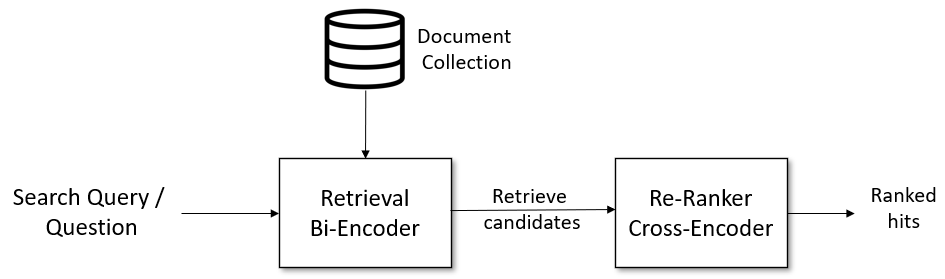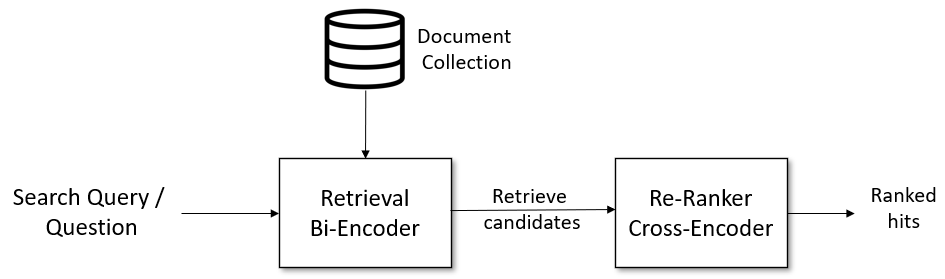

Reference:   

* [Milvus Reranking](https://milvus.io/docs/reranking.md)   
* [Milvus Hybrid Search](https://milvus.io/docs/multi-vector-search.md)

In [10]:
from pymilvus import AnnSearchRequest, RRFRanker, WeightedRanker

query_WeatherVector = "The current weather observation for New York, Kennedy International Airport[KJFK] in NY @ 40.767013,-73.696306 for is A Few Clouds with a temperature of  "
query_ImageVector = "camimages/yolo526f02df-16ee-4e52-9437-010c4e6bbcfd.png"

search_param_0 = {
    "data": [extractor(query_ImageVector)], # Query vector
    "anns_field": "image_vector", # Vector field name
    "param": {
        "metric_type": "COSINE", # This parameter value must be identical to the one used in the collection schema
    },
    "limit": 5 # Number of search results to return in this AnnSearchRequest
}

request_0 = AnnSearchRequest(**search_param_0)

search_param_1 = {
    "data": [model(query_WeatherVector)], # Query vector
    "anns_field": "weather_text_vector", # Vector field name
    "param": {
        "metric_type": "L2", # This parameter value must be identical to the one used in the collection schema
        "params": {"nprobe": 100}
    },
    "limit": 5 # Number of search results to return in this AnnSearchRequest
}
    
request_1 = AnnSearchRequest(**search_param_1)

reqs = [request_0, request_1]

# Rerank by RRF strategy
rerank = RRFRanker(k=60)

collection.load()

results = collection.hybrid_search(
    reqs, # List of AnnSearchRequests created in step 1
    rerank, # Reranking strategy specified in step 2
    output_fields=["id","latitude", "longitude","name","roadwayname","directionoftravel","videourl","url","filepath",
    "creationdate","areadescription","elevation","county","metar","weatherid","weathername","observationdate","temperature","dewpoint",
    "relativehumidity","windspeed","winddirection","gust","weather","visibility","altimeter","slp",
   "timezone","state","windchill","weatherdetails"],
    limit=3 # Number of final search results to return
)


# Display Our Results

We display the results of our re-ranked hybrid search of two vectors.  We show some of the output scalar fields and an image we read from the stored path.

The results from our hybrid search can be iterated and we can easily access all the output fields we choose.   *filepath*, contains the link to the locally stored image, and can be accessed from the *key.entity.filepath*.   The *key* contains all our results, while *key.entity* has all of our output fields chosen in our hybrid search in the previous step.   


The current weather observation for New York, Kennedy International Airport[KJFK] in NY @ 40.770817,-73.687524 for 27 Aug 19:51 pm EDT is A Few Clouds with a temperature of 74F, a dew point of 68 and relative humidity of 82% with a wind speed of 8190 with a visibility of 10.00 at an elevation of 148 and an altimeter reading of 1017.7 for the North Hills NY area.


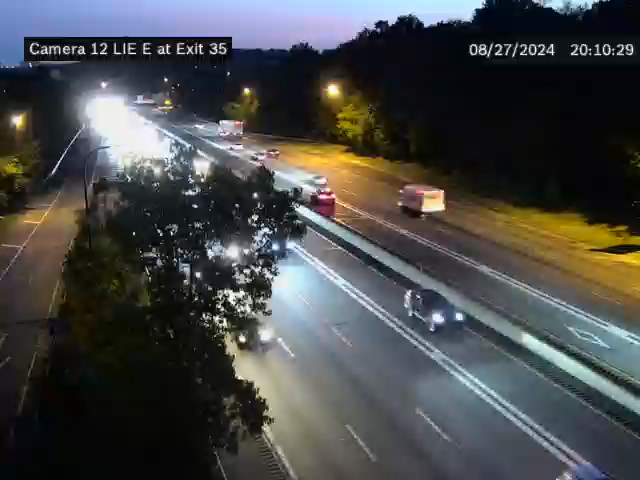

The current weather observation for New York, Kennedy International Airport[KJFK] in NY @ 40.774248,-73.670624 for 30 Aug 12:51 pm EDT is Mostly Cloudy with a temperature of 74F, a dew point of 61 and relative humidity of 64% with a wind speed of 1590 with a visibility of 10.00 at an elevation of 197 and an altimeter reading of 1024.7 for the NA area.


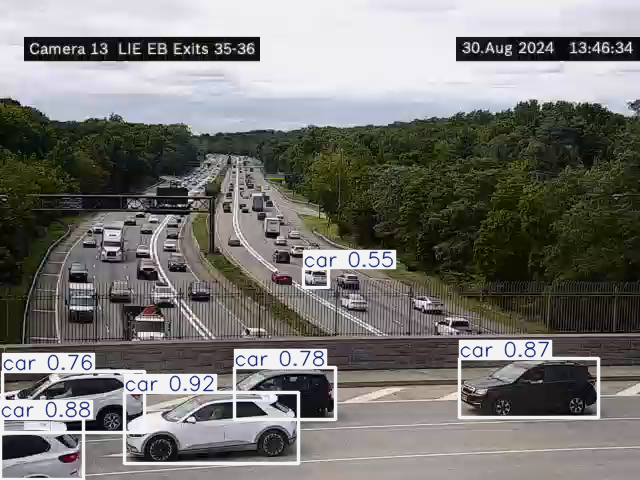

The current weather observation for New York, Kennedy International Airport[KJFK] in NY @ 40.770817,-73.687524 for 27 Aug 19:51 pm EDT is A Few Clouds with a temperature of 74F, a dew point of 68 and relative humidity of 82% with a wind speed of 8190 with a visibility of 10.00 at an elevation of 148 and an altimeter reading of 1017.7 for the North Hills NY area.


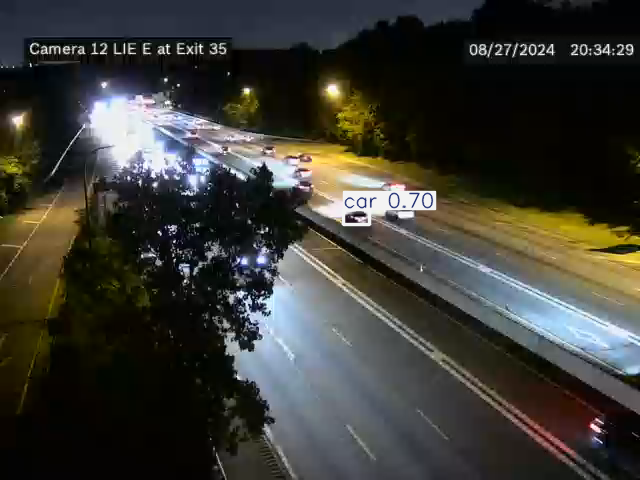

In [11]:
for index in range(len(results)):
    for key in results[index]:
        #print(key.id)
        #print(key.distance)
        #print(key.latlong)
        #print(key.entity.name)
        #print(key.entity.roadwayname)
        #print(key.entity.weathername)
        print(key.entity.weatherdetails)
        #print(key.entity.observationdate)
        #print(key.entity.temperature)
        img = Image.open(key.entity.filepath)
        display(img)
    

# Conclusion

In this notebook, you have seen how you can use Milvus to do a hybrid search on multiple vectors in the same collection and reranking the results. 
You also saw how to build a complex data modal that includes multiple vectors and many scalar fields that represent a lot of metadata related to our data.


## Resources

In the following list you can find resources helpful in learning more about using Pre-trained embedding models for Milvus, performing searches on text data and a great example notebook for embedding functions.

* https://github.com/milvus-io/bootcamp/blob/master/bootcamp/model/embedding_functions.ipynb
* https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2
* https://www.sbert.net/docs/sentence_transformer/pretrained_models.html
* https://milvus.io/api-reference/pymilvus/v2.4.x/EmbeddingModels/SentenceTransformerEmbeddingFunction/SentenceTransformerEmbeddingFunction.md
* https://medium.com/@zilliz_learn/vectorizing-json-data-with-milvus-for-similarity-search-1f546173162c
* https://docs.zilliz.com/reference/python/python/EmbeddingModels-SentenceTransformerEmbeddingFunction


# ⭐️ Github
We hope you liked this tutorial showcasing how to build and search complex data models with Milvus.
If you liked it and our project, please give us a star on [Github](https://github.com/milvus-io/milvus)! ⭐

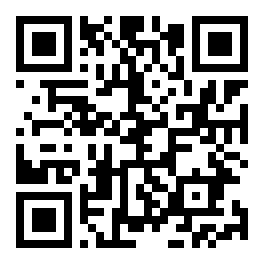


# 🤝 Add me on Linkedin!
If you have some questions related to Milvus, IoT, Streaming, Data Engineering, Edge AI, Kafka, NiFi, GenAI, etc, I am Tim Spann, you can add me on [LinkedIn](https://www.linkedin.com/in/timothyspann/) and I'll assist you in your Unstructured Data Journey to greatness.


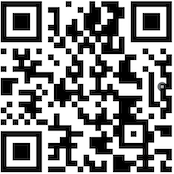




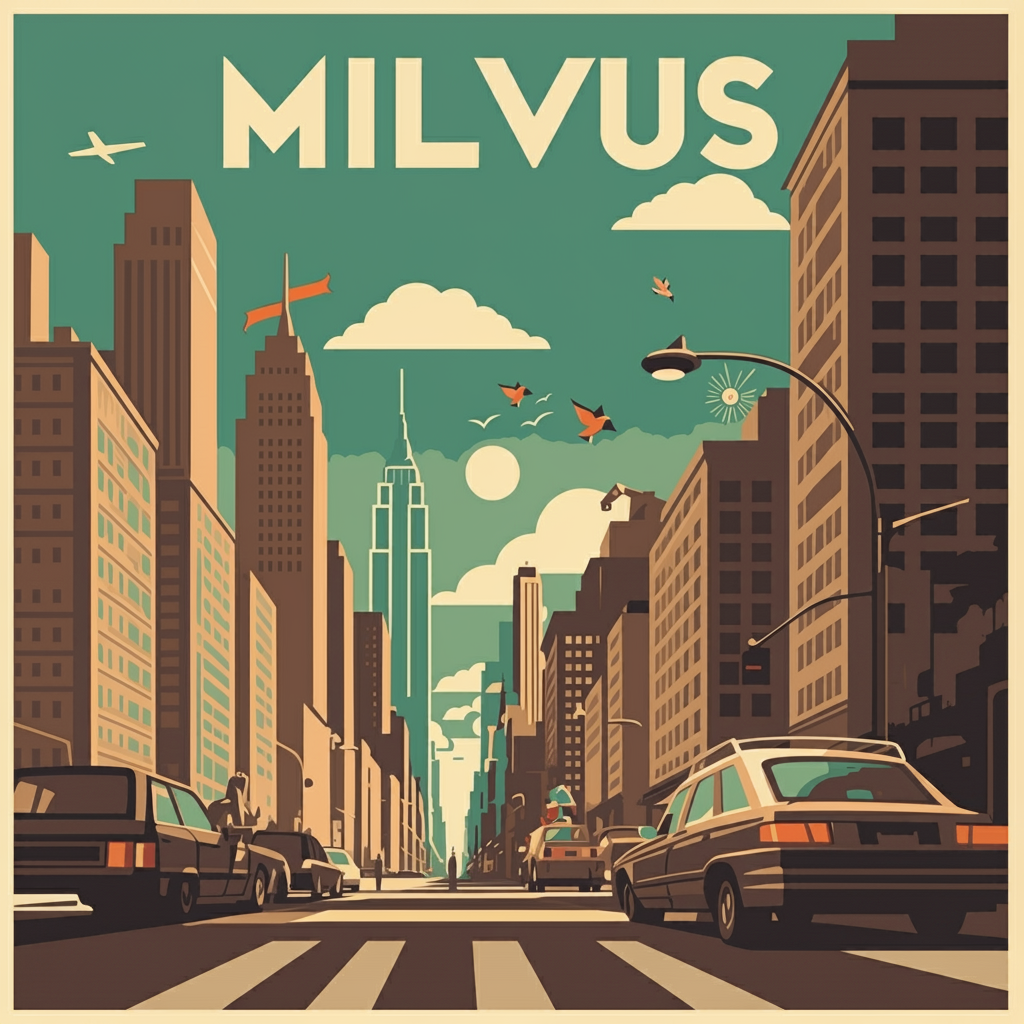